In [1]:
# libs basicas data science
from sklearn import datasets
import numpy as np
import pandas as pd
from scipy import stats
import math

#libs visualizacao
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from mlxtend.plotting import plot_decision_regions

#sklean model selection http://scikit-learn.org/
from sklearn.model_selection import cross_val_score, train_test_split

#sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# mlxtend classifiers https://rasbt.github.io/mlxtend/
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
sns.set(style="ticks")

# Iris Dataset

In [3]:
iris = datasets.load_iris()

In [4]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris.target_names[iris.target]], 
                       columns= iris['feature_names'] + ['class'])
for col in iris['feature_names']:
    iris_df[col] = pd.to_numeric(iris_df[col])

In [5]:
iris_df.shape

(150, 5)

In [6]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
iris_df.groupby('class').size()

class
setosa        50
versicolor    50
virginica     50
dtype: int64

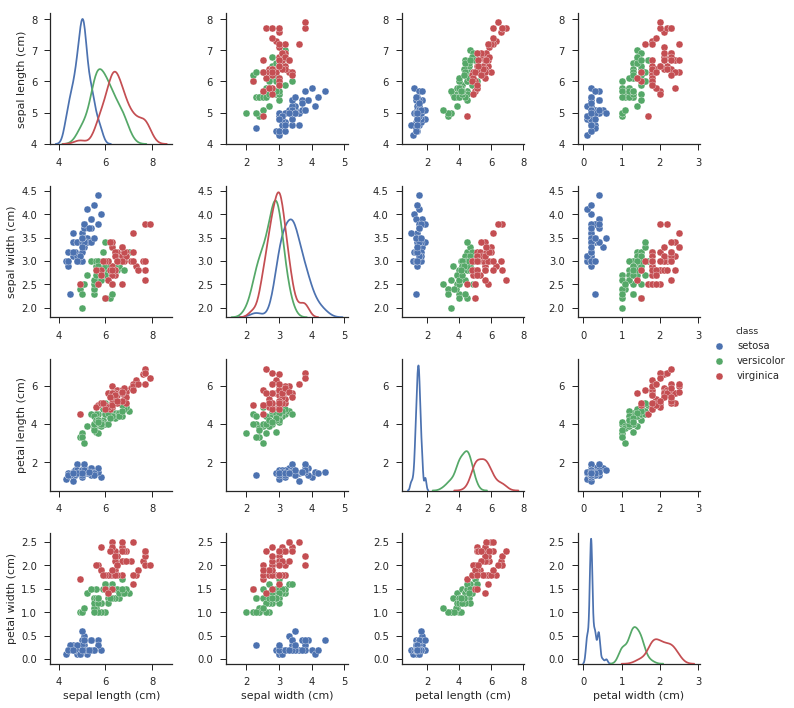

In [8]:
sns.pairplot(iris_df, hue="class", diag_kind="kde")
plt.show()

# Métodos utilitários

In [9]:
def get_predictions(models, X, y):
    validation_size = 0.20
    seed = 13
    X_train, X_validation, y_train, y_validation = \
        train_test_split(X, y, test_size=validation_size, random_state=seed)    
    predictions = [y_validation]
    labels = []
    for name in models.keys():
        model = models[name]
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_validation))
        labels.append(name)
    predictions_df = pd.DataFrame(data=np.transpose(predictions), columns=(['Y'] + list(models.keys()))) 
    return predictions_df

In [10]:
def models_correlation(predictions_df):
    corr = predictions_df.iloc[:, 1:].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu")
    plt.show()

In [11]:
def highlight_error(s):
    is_error = s != s.iloc[0]
    return ['color: red' if v else 'color: black' for v in is_error]

In [12]:
def print_predictions(models, X, y):
    predictions_df = get_predictions(models, X, y)
    return predictions_df.style.apply(highlight_error, axis=1)

In [13]:
def train_and_report(models, X, y):
    results = []
    for name in models.keys():
        model = models[name]
        scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        print("Accuracy: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), name))

In [14]:
def plot_decision_boundaries(models, X, y, cols=3):
        
    fig = plt.figure()
    rows = math.ceil(len(models) / (cols * 1.0))
    gs = gridspec.GridSpec(rows, cols)
    grid = []
    for r in range(rows):
        for c in range(cols):
            grid.append((r,c))

    clf_list = models.values()
    labels = models.keys()
    
    for clf, label, grd in zip(clf_list, labels, grid):
        
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(label)

    plt.show()

# Treinamento dos modelos isoladamente

In [15]:
X, y = iris.data[:, 0:2], iris.target

In [16]:
models = {}
models['LR'] = LogisticRegression()
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier(random_state=13)
models['NB'] = GaussianNB()
models['SVC'] = SVC(probability=True)

In [17]:
train_and_report(models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.793 (+/- 0.096) [LDA]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.667 (+/- 0.094) [CART]
Accuracy: 0.793 (+/- 0.087) [NB]
Accuracy: 0.813 (+/- 0.078) [SVC]


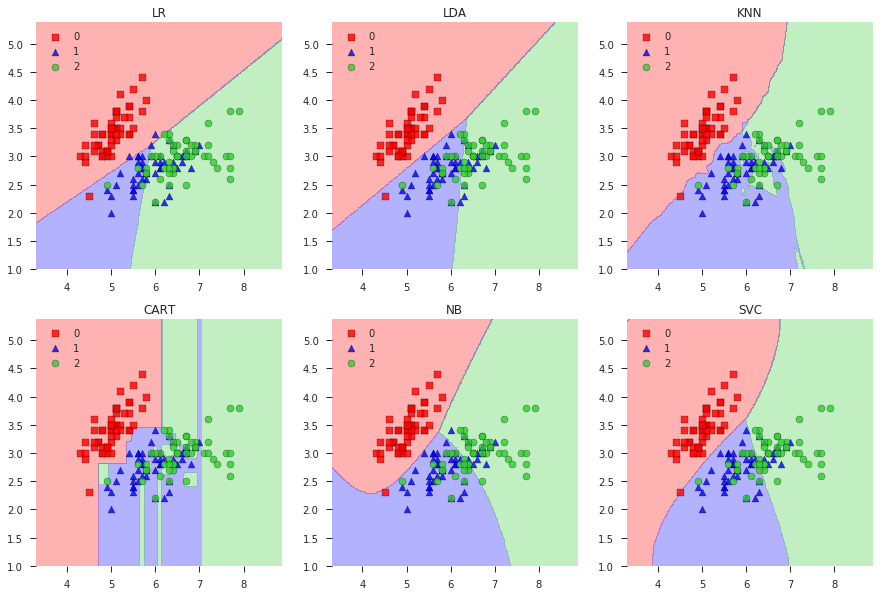

In [18]:
plot_decision_boundaries(models, X, y)

# Votação

## Maioria

In [19]:
voting_models_names = models.keys()
#voting_models_names = ['LR', 'KNN', 'LDA']
voting_models = {name: models[name] for name in voting_models_names}
voting_estimators = [(name, models[name]) for name in voting_models_names]

In [20]:
print_predictions(voting_models, X, y)

,Y,LR,LDA,KNN,CART,NB,SVC
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0
3,2,1,1,1,1,1,1
4,2,2,2,1,1,2,2
5,0,0,0,0,0,0,0
6,2,2,2,2,2,2,2
7,2,1,1,2,2,1,1
8,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1


In [21]:
voting_models['MAJORITY'] = VotingClassifier(estimators=voting_estimators, voting='hard')

In [22]:
train_and_report(voting_models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.793 (+/- 0.096) [LDA]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.667 (+/- 0.094) [CART]
Accuracy: 0.793 (+/- 0.087) [NB]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.820 (+/- 0.085) [MAJORITY]


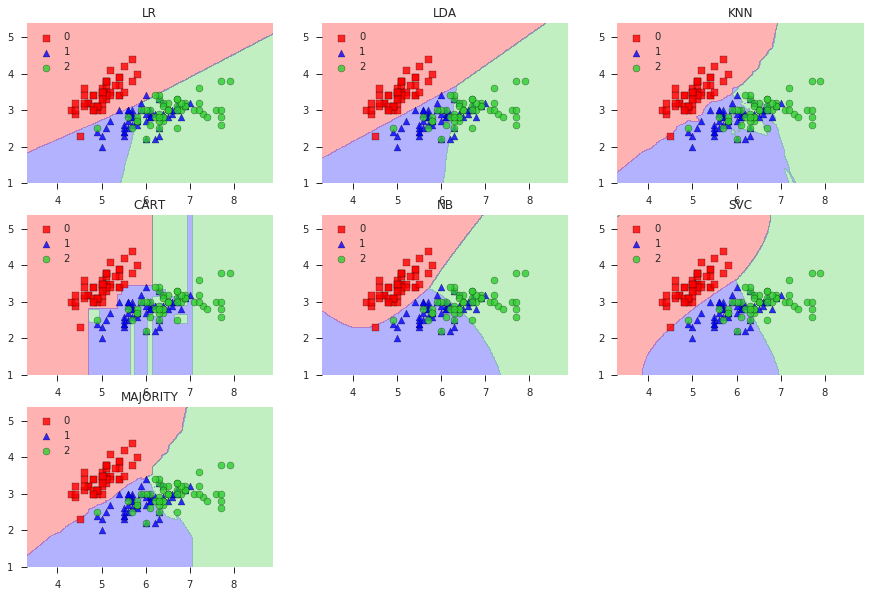

In [23]:
plot_decision_boundaries(voting_models, X, y)

In [24]:
print_predictions(voting_models, X, y)

,Y,LR,LDA,KNN,CART,NB,SVC,MAJORITY
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0
3,2,1,1,1,1,1,1,1
4,2,2,2,1,1,2,2,2
5,0,0,0,0,0,0,0,0
6,2,2,2,2,2,2,2,2
7,2,1,1,2,2,1,1,1
8,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1


## Ponderado

In [25]:
voting_models['WEIGHT_AVG'] = VotingClassifier(estimators=voting_estimators,
                                                        #weights=[0.7,0.7,1.0],
                                                        voting='soft')

In [26]:
train_and_report(voting_models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.793 (+/- 0.096) [LDA]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.667 (+/- 0.094) [CART]
Accuracy: 0.793 (+/- 0.087) [NB]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.820 (+/- 0.085) [MAJORITY]
Accuracy: 0.767 (+/- 0.100) [WEIGHT_AVG]


In [27]:
print_predictions(voting_models, X, y)

,Y,LR,LDA,KNN,CART,NB,SVC,MAJORITY,WEIGHT_AVG
0,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0
3,2,1,1,1,1,1,1,1,1
4,2,2,2,1,1,2,2,2,1
5,0,0,0,0,0,0,0,0,0
6,2,2,2,2,2,2,2,2,2
7,2,1,1,2,2,1,1,1,2
8,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1


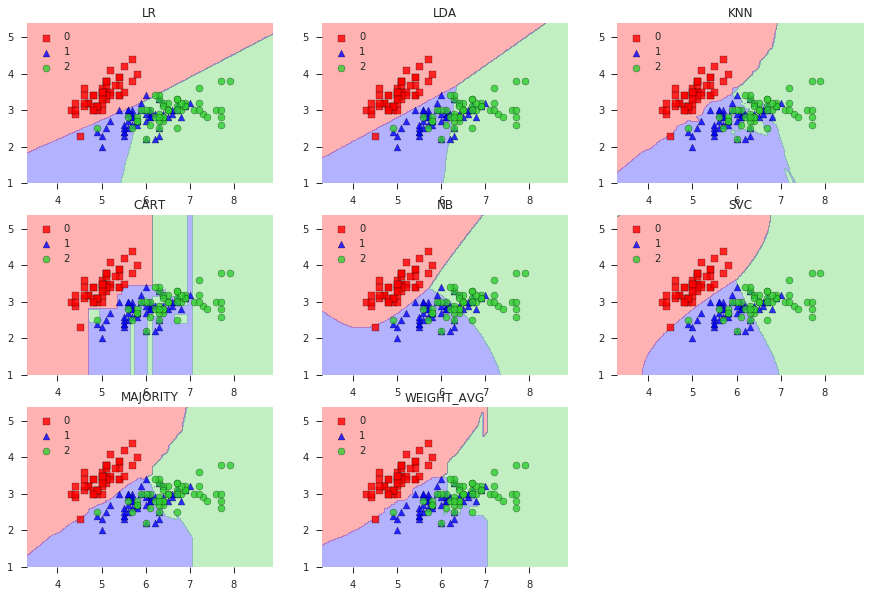

In [28]:
plot_decision_boundaries(voting_models, X, y)

## Correlação entre os modelos

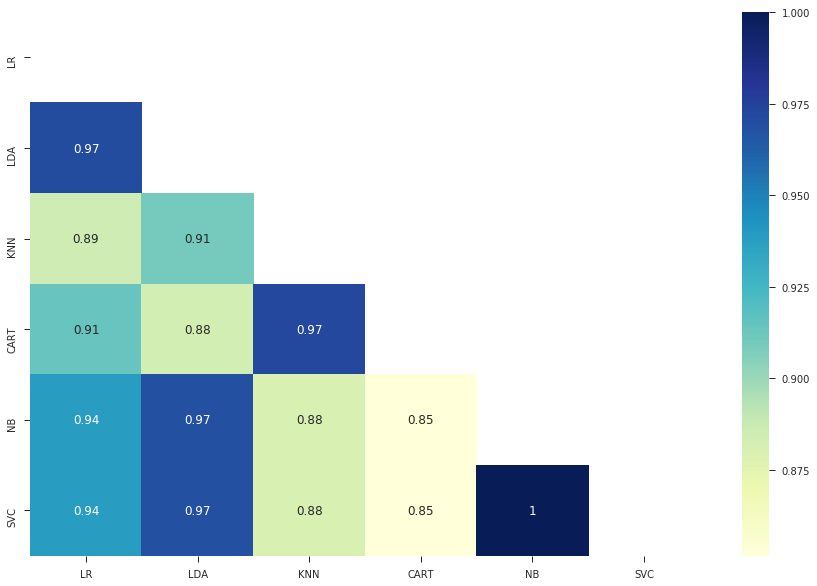

In [29]:
predictions = get_predictions(models, X, y)
models_correlation(predictions)

# Meta-Classificador

In [30]:
Image(url= "https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png")

In [31]:
#meta_models_names = ['LR', 'KNN', 'CART']
meta_models_names = models.keys()
meta_models = {name: models[name] for name in meta_models_names}
meta_estimators = [models[name] for name in meta_models_names]

In [32]:
meta = StackingClassifier(classifiers=meta_estimators,
                            use_probas=True,
                            average_probas=True,
                            meta_classifier=models['LR'])

In [33]:
meta_models['META'] = meta

In [34]:
train_and_report(meta_models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.793 (+/- 0.096) [LDA]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.667 (+/- 0.094) [CART]
Accuracy: 0.793 (+/- 0.087) [NB]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.767 (+/- 0.100) [META]
